#### Aug. 10, 2018 320pm

In [1]:
import numpy   as np
import pandas  as pd
import pickle
import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

---

#### Function Definitions

In [2]:
def time_Now():
    import datetime
    import pytz
    utc_now = pytz.utc.localize(datetime.datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("America/Los_Angeles"))
    return (pst_now)

In [3]:
import itertools 
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label',  fontsize=14)
    plt.xlabel('Predicted label',  fontsize=14)

In [4]:
def plot_model_ROC(model, X_df, y_true, figTitle=None, printMetrics=False, figName=None):
    '''
        Function will plot the Model's ROC curve with several options:
        - alter the fig TITLE
        - APPEND model metrics to the figure
        - SAVE figure as a *.png and a*.pdf file
        
        Function will execute with only 3 of the 6 parameters
        - sklearn model that can give a predict_proba
        - X_df to apply the predict_proba
        - y_true the true values to compute TPR and FPR (T/F positive rates)
    '''
    
    pred = model.predict(X_df)
    y_score = model.predict_proba(X_df)[:,1]

    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, 'o--')
    plt.plot(np.linspace(0,1), np.linspace(0,1), 'k--')
    plt.ylabel("True Positive Rate",  fontsize=14)
    plt.xlabel("False Positive Rate", fontsize=14);
    plt.text(.6, .1, "AUC score: {0:.4f}".format( roc_auc_score(y_test, y_score) ), fontsize=14);
    
    if figTitle:
        plt.title(figTitle)
    else:
        plt.title(str(model))
        
    if printMetrics:
        plt.text(.6, .15, "Accuracy score: {0:.4f}".format( accuracy_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .2, "Precision score: {0:.4f}".format( precision_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .25, "Recall score: {0:.4f}".format( recall_score(y_true, pred) ), fontsize=14);
        plt.text(.6, .3, "F1 score: {0:.4f}".format( f1_score(y_true, pred) ), fontsize=14);

    if figName:
        print("saving..." + figName)
        plt.gcf()
        plt.savefig(figName + '.png')
        plt.savefig(figName + '.pdf')

---
### Modified: 

In [5]:
print("Last modified on: ", time_Now())

Last modified on:  2018-08-12 12:12:55.435133-07:00


---

### Large Pickled Dataset



In [6]:
%%time
full_df = pd.read_pickle("newRev_VegCols_US.pkl")

CPU times: user 744 ms, sys: 548 ms, total: 1.29 s
Wall time: 1.3 s


In [7]:
%%time
df = full_df[full_df['useful'] != 0]

CPU times: user 84 ms, sys: 28 ms, total: 112 ms
Wall time: 108 ms


In [8]:
df.head(2)

,business_id,name,review_id,stars,date,text,useful,funny,cool,city,state,vegFriendly,Vegan,Vegetarian,Thai,Italian,Indian,Chinese,Mexican,Text_length
0,7eQoxWr9RzyCB9IFvqHUPA,Pizza Heaven Bistro,--4aCc43T0_g960EaIRf-w,4,2013-12-09,I was soooo happy when i open the menu and the...,4,0,4,Phoenix,AZ,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,186
2,-8QlV3b_9H4BAh6LgMIr1g,Nandini Indian Cuisine,--c6GUtseZhMHA0rSfnN8w,5,2015-09-30,"This was our second, but certainly not our las...",1,0,1,Tempe,AZ,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,304


In [9]:
%%time
X_df = df.drop(['vegFriendly', 'Vegan', 'Vegetarian'], axis=1)
y_df = df['vegFriendly']

CPU times: user 52 ms, sys: 8 ms, total: 60 ms
Wall time: 56.7 ms


In [10]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408082 entries, 0 to 923001
Data columns (total 17 columns):
business_id    408082 non-null object
name           408082 non-null object
review_id      408082 non-null object
stars          408082 non-null int64
date           408082 non-null datetime64[ns]
text           408082 non-null object
useful         408082 non-null int64
funny          408082 non-null int64
cool           408082 non-null int64
city           408082 non-null object
state          408082 non-null object
Thai           408082 non-null float64
Italian        408082 non-null float64
Indian         408082 non-null float64
Chinese        408082 non-null float64
Mexican        408082 non-null float64
Text_length    408082 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(5), object(6)
memory usage: 56.0+ MB


In [11]:
%%time
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: re.sub(r'(\d+)', '', rev) )

CPU times: user 8.61 s, sys: 84 ms, total: 8.69 s
Wall time: 8.69 s


In [12]:
%%time
X_df.iloc[:, 5] = X_df['text'].apply( lambda rev: rev.replace('_', '') )

CPU times: user 344 ms, sys: 0 ns, total: 344 ms
Wall time: 340 ms


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3)

In [14]:
print( X_train.shape, X_test.shape)

(285657, 17) (122425, 17)


---

### Manipulate data sets

In [15]:
stopWords = list(stopwords.words('english'))
stopWords.extend(['good', 'excellent', 'best', 'like', 'place', 'really', 'ordered', 'amazing', 'fantastic', 'am', 'pm'])
stopWords.extend(['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuggggggggggggggggggg', 'aaaaaaah'])
stopWords.extend(['aaaaaaamazing', 'aaaaaaand', 'aaaaaamazing', 'aaaaahhhh', 'aaaaahhhhhhmazing', 'aaaaahhhhmaaazeballs', 'aaaaamazing', 'aaaaand'])
stopWords.extend(['aaaack', 'aaaamazing', 'aaaammmazziiigggg', 'aaaand', 'aaaarrgh', 'aaah', 'aaahh'])
stopWords.extend(['aaahhhh', 'aaahhhhh', 'aaahhhhmmmaaazzziiiinnnnggg'])
stopWords.extend(['aaammaziiiing', 'aaand', 'aab', 'aaboud', 'aac', 'aachi', 'aadd', 'aaggh', 'aagh', 'aah', 'aahan', 'aahc', 'aahhh'])
stopWords.extend(['aahhhh', 'aahhhhhh', 'aahhhhhhmazing', 'aahhhhhmazing', 'aahhhhmazing', 'aahing', 'aahran'])
stopWords.extend(['aaaaaaaaaa', 'aaaaaaaaaaaaaand', 'aaaaaaaaaaaaaauthentic', 'aaaaaaaaaaaaaawwwwwwwwwwwwwwwwwwwwww', 'aaaaaaaaaaack', 'aaaaaaaaaaah', 'aaaaaaaaaand', 'aaaaaaaaargh', 'aaaaaaaack', 'aaaaaaaahhhhhhhhh', 'aaaaaaaamazing', 'aaaaaaaand', 'aaaaaaall', 'aaaaaaamaaaaazing', 'aaaaaaammmmazing', 'aaaaaahhhh', 'aaaaaahhhhh', 'aaaaaahhhhhmazing', 'aaaaaand', 'aaaaaannnddd', 'aaaaaannnndddd', 'aaaaagh', 'aaaaah', 'aaaaahhhhmazing', 'aaaaamaaazing', 'aaaaammmaazzzinnngg', 'aaaaarrrggghh', 'aaaaawful', 'aaaaay', 'aaaagh', 'aaaah', 'aaaahh', 'aaaahhh', 'aaaahhhh', 'aaaahhhhhhh', 'aaaahmazzzing', 'aaaajúa', 'aaaall', 'aaaalllllllll', 'aaaallright', 'aaaammaaazzinnnggg', 'aaaammazzing', 'aaaammmaaaaazzzziiiinnnngggg', 'aaaammmaaazing', 'aaaammmmmmazing', 'aaaamzing', 'aaaandd', 'aaaanddd', 'aaaannnd', 'aaaannnnd', 'aaaanyway', 'aaaawesoooome', 'aaaawwwesome', 'aaaawwwww', 'aaagggrrrrrrrhhhhh', 'aaahahaa', 'aaahhh', 'aaahhhhhhh', 'aaahhhs', 'aaahing', 'aaahmaaaazing', 'aaahmazing', 'aaahs', 'aaaiiiiight', 'aaall', 'aaallll', 'aaalways', 'aaamaazing', 'aaamazing', 'aaammaaazzziinnnngggg', 'aaammazing', 'aaammmazing', 'aaammmazinggggg', 'aaammmmaaazzziinnggg', 'aaannd', 'aaanndd', 'aaannndd', 'aaannnnd', 'aaanyway', 'aaare', 'aaawwee', 'aaawww', 'aaawwwwsome', 'aaay', 'aacross', 'aadbcc', 'aadorbsssssss', 'aagain', 'aahaan', 'aahed', 'aahh', 'aahs', 'aaid', 'aaiight', 'aaiiight', 'aaim', 'aaka', 'aaked', 'aaliyah', 'aall'])
stopWords.extend(['aaaaaaaaaaaaahhhhhhh', 'aaaaaaaaaah', 'aaaaaaaahhhhmazing', 'aaaaaaaawesooooooooooooome', 'aaaaaaggghhh', 'aaaaaah', 'aaaaaawesome', 'aaaaahhh', 'aaaaahhhhhh', 'aaaahhhhhhs', 'aaaajua', 'aaaalmost', 'aaaamazzzzing', 'aaaammaaazzziiingggg', 'aaaarreeeee', 'aaagh', 'aaahed', 'aaahhhmaaaazing', 'aaahhhmazing', 'aaammaazzing', 'aaarghhh', 'aahaha', 'aahhhhhaaaahhhhh'])

In [16]:
vectorizer = TfidfVectorizer(stop_words=stopWords, strip_accents = 'ascii' )

#### Vectorize Review Text

In [17]:
%%time
X_train_term  = vectorizer.fit_transform(X_train['text'])

CPU times: user 24.8 s, sys: 340 ms, total: 25.2 s
Wall time: 25.2 s


In [18]:
X_train_term.shape

(285657, 105794)

In [19]:
ftrs = vectorizer.get_feature_names()
# ftrs

In [20]:
# len(vectorizer.get_stop_words())

---

#### Mutlinomial NB - Train

In [21]:
%%time
M_NB_model = MultinomialNB()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 13.1 µs


In [22]:
%%time
M_NB_model.fit(X_train_term, y_train)

CPU times: user 156 ms, sys: 0 ns, total: 156 ms
Wall time: 157 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

---

#### Multinomial NB - Test

In [23]:
%%time
X_test_term = vectorizer.transform(X_test['text'])

CPU times: user 10.9 s, sys: 44 ms, total: 10.9 s
Wall time: 10.9 s


In [24]:
X_test_term.shape

(122425, 105794)

In [25]:
%%time
pred = M_NB_model.predict(X_test_term)

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 42.7 ms


In [26]:
# accuracy_score(y_test, pred)

# precision_score(y_test, pred)

# recall_score(y_test, pred)

# f1_score(y_test, pred)

In [27]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

        0.0       0.83      1.00      0.90     96787
        1.0       0.92      0.20      0.33     25638

avg / total       0.85      0.83      0.78    122425



Confusion matrix, without normalization


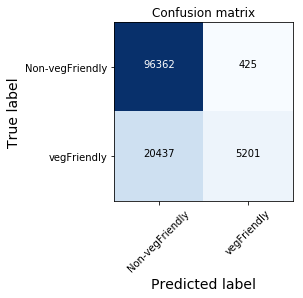

In [28]:
cm = confusion_matrix(y_test, pred)
lbls = ['Non-vegFriendly', 'vegFriendly']

plot_confusion_matrix(cm,lbls)

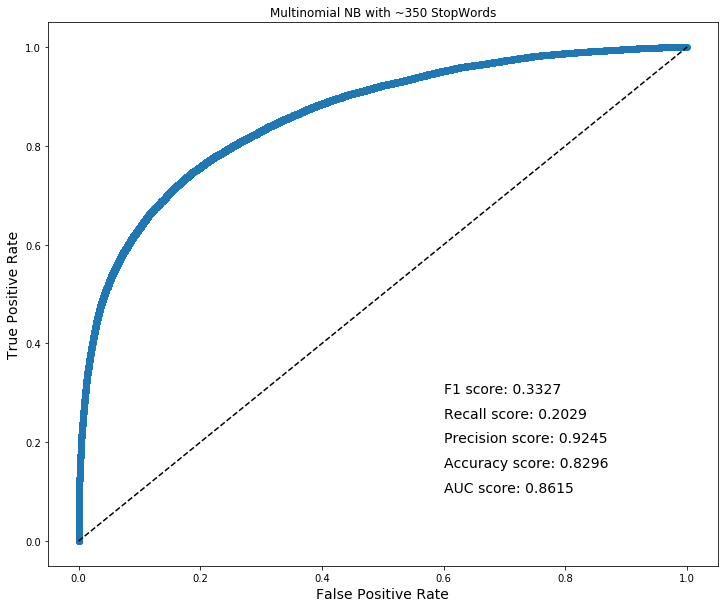

In [29]:
fTitle = 'Multinomial NB with ~350 StopWords'
mMetrics = True
fName = 'MNB_357StWds'
plot_model_ROC(M_NB_model, X_test_term, y_test, fTitle, mMetrics)